In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import openmm.unit as unit
import scipy as sc
from MDAnalysis import Universe
from openmmtools.alchemy import (
    AbsoluteAlchemicalFactory,
    AlchemicalRegion,
    AlchemicalState,
)
from paprika.analysis import get_block_sem, get_nearest_max, integrate_bootstraps
from paprika.io import PaprikaEncoder
from simtk.openmm import LangevinIntegrator, Platform, Vec3, XmlSerializer
from simtk.openmm.app import PDBFile, Simulation
from tqdm.notebook import tqdm

/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


# Initialize

In [2]:
# device_ID = "1"
ligand_resname = "LIG"
base_folder = "../electrostatics-bulk"
boot_cycles = 1000
d_lambda = 0.001
lambda_values = np.linspace(0, 1, 11)[::-1]
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

universe = Universe(
    f"{base_folder}/ligand.pdb",
    f"{base_folder}/production-1.dcd",
    in_memory=True,
)
n_frames = universe.trajectory.n_frames
Temp = 298.15 * unit.kelvin
RT = unit.AVOGADRO_CONSTANT_NA * unit.BOLTZMANN_CONSTANT_kB * Temp
dt = 2.0 * unit.picosecond
n_lambda = len(lambda_values)
derivative = np.zeros((n_lambda, n_frames))

In [3]:
# Load XML and PDB file
with open(f"{base_folder}/ligand.xml", "r") as f:
    system = XmlSerializer.deserialize(f.read())
coords = PDBFile(f"{base_folder}/ligand.pdb")

# Alchemical stuff
alchemical_atoms = [
    atom.index
    for atom in coords.topology.atoms()
    if atom.residue.name == ligand_resname
]
alchemical_factory = AbsoluteAlchemicalFactory(
    consistent_exceptions=False,
    alchemical_pme_treatment="exact",
    disable_alchemical_dispersion_correction=False,
)
alchemical_region = AlchemicalRegion(
    alchemical_atoms=alchemical_atoms,
    annihilate_electrostatics=True,
    annihilate_sterics=False,
)
system = alchemical_factory.create_alchemical_system(system, alchemical_region)
alchemical_state = AlchemicalState.from_system(system)

integrator = LangevinIntegrator(Temp, 1.0 / unit.picoseconds, dt)

# Create Simulation Object
simulation = Simulation(
    coords.topology,
    system,
    integrator,
    Platform.getPlatformByName("CUDA"),
    #     {"CudaDeviceIndex": device_ID, "CudaPrecision": "mixed"},
    {"CudaPrecision": "mixed"},
)

# Calculate derivative

In [4]:
# Calculate reduced potential
for k in tqdm(range(n_lambda)):
    universe = Universe(
        f"{base_folder}/ligand.pdb",
        f"{base_folder}/production-{k+1}.dcd",
        in_memory=True,
    )
    sel = universe.select_atoms("all")

    # Reweighted lambda values
    if lambda_values[k] == 0.0:
        # Forward difference
        lb1 = lambda_values[k]
        lb2 = lambda_values[k] + d_lambda
        dd_lambda = d_lambda
    elif lambda_values[k] == 1.0:
        # Reverse difference
        lb1 = lambda_values[k] - d_lambda
        lb2 = lambda_values[k]
        dd_lambda = d_lambda
    else:
        # Central difference
        lb1 = lambda_values[k] - d_lambda
        lb2 = lambda_values[k] + d_lambda
        dd_lambda = 2.0 * d_lambda

    for n, ts in enumerate(universe.trajectory):
        simulation.context.setPositions(sel.positions * unit.angstrom)

        # Get Energies
        simulation.context.setParameter("lambda_electrostatics", lb1)
        dU_1 = simulation.context.getState(getEnergy=True).getPotentialEnergy()
        simulation.context.setParameter("lambda_electrostatics", lb2)
        dU_2 = simulation.context.getState(getEnergy=True).getPotentialEnergy()

        # Calculate Derivative
        derivative[k, n] = (dU_2 - dU_1).value_in_unit(
            unit.kilocalorie_per_mole
        ) / dd_lambda

    del universe
    del sel

np.save(f"{base_folder}/derivative_TI_elec.npy", derivative)

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0, 0.5, 'dU/dlambda (kcal/mol)')

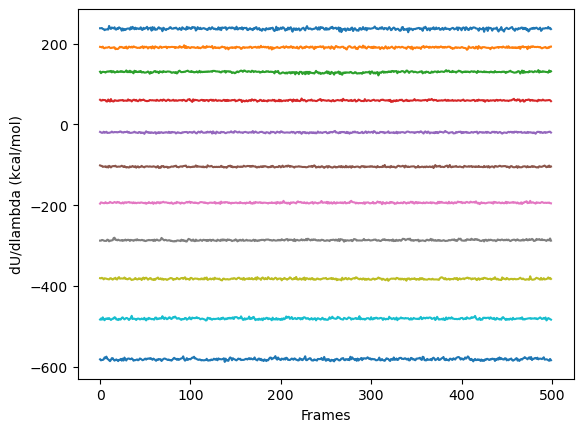

In [5]:
plt.figure(dpi=100)
for i in range(len(lambda_values)):
    plt.plot(derivative[i, :])

plt.xlabel("Frames")
plt.ylabel("dU/dlambda (kcal/mol)")

# Calculate FE profile

In [6]:
dl_intp = np.zeros([0], np.float64)
for k in range(n_lambda):
    if k > 0:
        dl_intp = np.append(
            dl_intp,
            np.linspace(
                lambda_values[k - 1], lambda_values[k], num=100, endpoint=False
            ),
        )
dl_intp = np.append(dl_intp, lambda_values[-1])

In [7]:
results = {
    "fraction_n_frames": {},
    "fraction_fe_matrix": {},
    "fraction_sem_matrix": {},
    "fraction_fe": {},
    "fraction_sem": {},
    "n_frames": None,
    "fe": None,
    "sem": None,
    "fe_matrix": None,
    "sem_matrix": None,
}

for fraction in tqdm(fractions):
    dU_avgs = np.mean(derivative[:, 0 : int(fraction * n_frames)], axis=-1)
    dU_sems = np.zeros(n_lambda)

    nearest_max = get_nearest_max(int(fraction * n_frames))
    for k in range(n_lambda):
        dU_sems[k] = get_block_sem(derivative[k, 0:nearest_max])

    dU_samples = np.random.normal(dU_avgs, dU_sems, size=(boot_cycles, n_lambda))

    (
        results["fraction_fe_matrix"][fraction],
        results["fraction_sem_matrix"][fraction],
    ) = integrate_bootstraps(
        lambda_values[::-1],
        dU_samples[:, ::-1],
        x_intp=dl_intp[::-1],
        matrix="diagonal",
    )
    results["fraction_fe"][fraction] = results["fraction_fe_matrix"][fraction][0, -1]
    results["fraction_sem"][fraction] = results["fraction_sem_matrix"][fraction][0, -1]

    results["fraction_n_frames"][fraction] = int(fraction * n_frames) * n_lambda

max_fraction = np.max(fractions)
results["fe_matrix"] = results["fraction_fe_matrix"][max_fraction]
results["sem_matrix"] = results["fraction_sem_matrix"][max_fraction]

results["fe"] = -1 * results["fe_matrix"][0, -1]
results["sem"] = results["sem_matrix"][0, -1]

results["n_frames"] = n_frames * n_lambda

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
print(f"Delta G(elec) = {results['fe']:.2f} +- {results['sem']:.2f} kcal/mol")

Delta G(elec) = 125.74 +- 0.06 kcal/mol


In [9]:
with open(f"{base_folder}/ti_results.json", "w") as f:
    dumped = json.dumps(results, cls=PaprikaEncoder)
    f.write(dumped)

In [10]:
with open(f"{base_folder}/ti-fe.csv", "w") as f:
    f.writelines("#lambda, FE, Error\n")
    for i in range(n_lambda):
        f.writelines(
            "%.5f,%.4f,%.4f\n"
            % (
                lambda_values[i],
                -1*results["fe_matrix"][0, i],
                results["sem_matrix"][0, i],
            )
        )

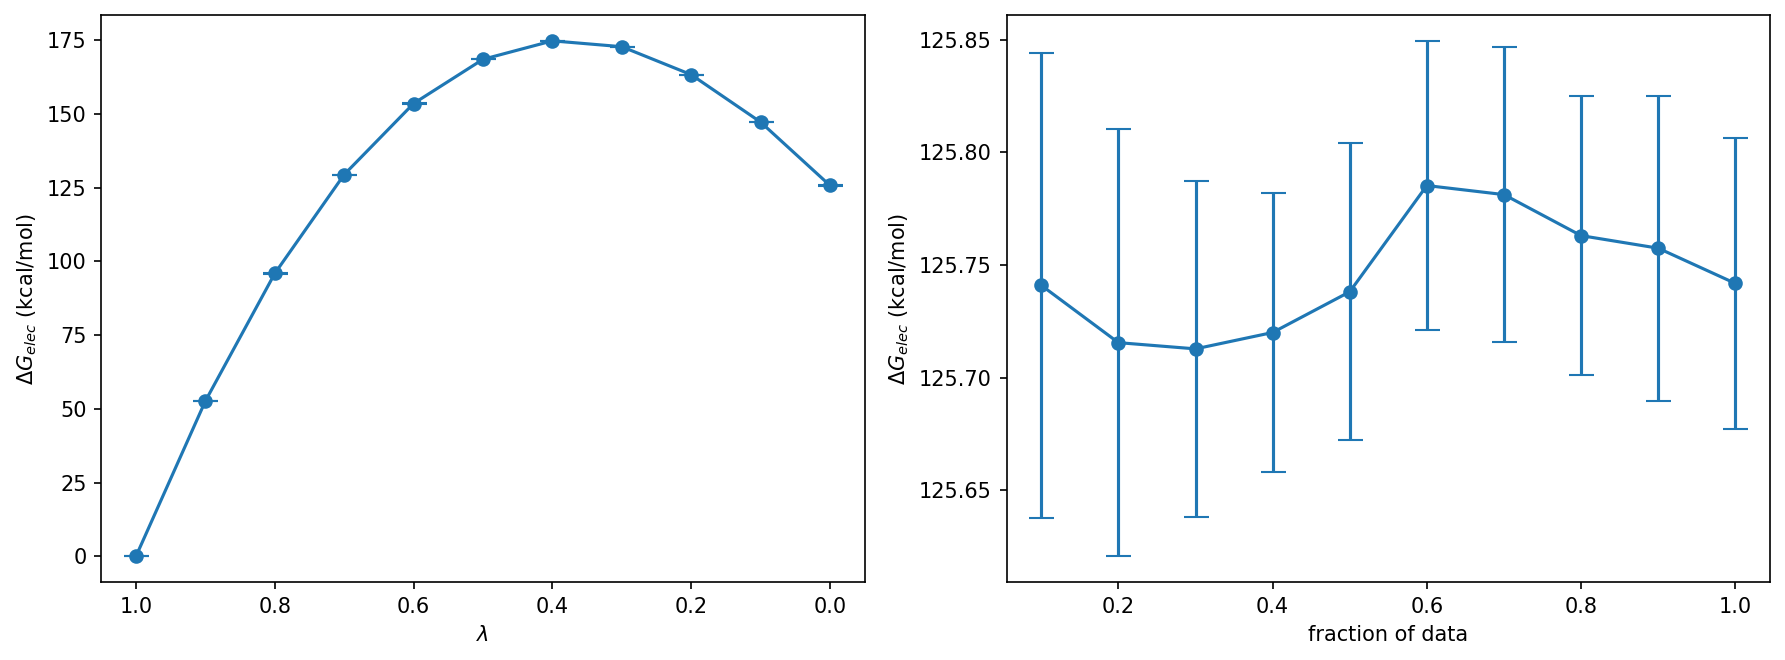

In [11]:
plt.figure(dpi=150, figsize=(12, 4.5))
plt.subplot(1, 2, 1)
plt.errorbar(
    lambda_values,
    -1 * results["fe_matrix"][0, :],
    yerr=results["sem_matrix"][0, :],
    fmt="-o",
    capsize=6,
)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\Delta G_{elec}$ (kcal/mol)")
plt.tight_layout()
plt.gca().invert_xaxis()

plt.subplot(1, 2, 2)
fe_fraction = [-1 * results["fraction_fe"][i] for i in results["fraction_fe"]]
sem_fraction = [results["fraction_sem"][i] for i in results["fraction_sem"]]
plt.errorbar(fractions, fe_fraction, yerr=sem_fraction, fmt="-o", capsize=6)
plt.xlabel(r"fraction of data")
plt.ylabel(r"$\Delta G_{elec}$ (kcal/mol)")
plt.tight_layout()